**Thyroid Disease Prediction Using Machine Learning**

This project builds a machine learning pipeline to predict thyroid disease using data preprocessing, anomaly detection, class balancing, and XGBoost classification.

In [73]:
# Import The Required Libraries

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import KMeansSMOTE

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
# Load the Dataset

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/thyroid.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Create Target Variable

df["target"] = np.where(df["class"] == "negative", 0, 1)

df.head()


,patient_id,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,referral source,class,dataset_name,target
0,1,41.0,0.0,0,0,0,0,0,0,0,...,125.0,1,1.14,1,109.0,0,SVHC,negative,allrep,0
1,2,23.0,0.0,0,0,0,0,0,0,0,...,102.0,0,NaN,0,NaN,0,other,negative,allrep,0
2,3,46.0,1.0,0,0,0,0,0,0,0,...,109.0,1,0.91,1,120.0,0,other,negative,allrep,0
3,4,70.0,0.0,1,0,0,0,0,0,0,...,175.0,0,NaN,0,NaN,0,other,replacement therapy,allrep,1
4,5,70.0,0.0,0,0,0,0,0,0,0,...,61.0,1,0.87,1,70.0,0,SVI,negative,allrep,0


In [48]:
# Drop unnecessary columns

drop_cols = ["class", "dataset_name", "patient_id"]
drop_cols = [c for c in drop_cols if c in df.columns]

df.drop(columns=drop_cols, inplace=True)


In [49]:
# Encode Categorical Features using LabelEncoder

cat_cols = df.select_dtypes(include="object").columns

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [50]:
# Handle Missing Values using median

df.replace("?", np.nan, inplace=True)

# Numeric → median
for col in df.columns:
    if df[col].dtype != "object":
        df[col] = df[col].fillna(df[col].median())

In [51]:
X = df.drop("target", axis=1)
y = df["target"]


In [52]:
# Feature Scaling using StandardScalar

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
# Outlier Detection using Isolation Forest

clean_indices = []

for cls in np.unique(y):
    idx = np.where(y == cls)[0]
    iso = IsolationForest(contamination=0.05, random_state=42)
    preds = iso.fit_predict(X_scaled[idx])
    clean_indices.extend(idx[preds == 1])

X_clean = X_scaled[clean_indices]
y_clean = y[clean_indices]


print("Original shape:", X_scaled.shape)
print("After Isolation Forest:", X_clean.shape)


Original shape: (22632, 28)
After Isolation Forest: (21500, 28)


In [74]:
# Class balancing using KmeansSMOTE

# Initialize KMeans-SMOTE
smote = KMeansSMOTE(
    random_state=42,
    k_neighbors=3,
    cluster_balance_threshold=0.01
)

# Apply resampling
X_bal, y_bal = smote.fit_resample(X_clean, y_clean)

In [75]:
# Split Data into Train and Test Sets

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.2,
    stratify=y_bal,
    random_state=42
)


In [76]:
# Train Final XGBoost Classifier

xgb_model = XGBClassifier(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage
    max_depth=6,             # Tree depth
    subsample=0.8,           # Row sampling
    colsample_bytree=0.8,    # Column sampling
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [05:55:19] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [77]:
# Model Evaluation

y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\n",classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:\n", cm)


Accuracy: 0.9472853151949472

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      4116
           1       0.94      0.95      0.95      4117

    accuracy                           0.95      8233
   macro avg       0.95      0.95      0.95      8233
weighted avg       0.95      0.95      0.95      8233


 Confusion Matrix:
 [[3887  229]
 [ 205 3912]]


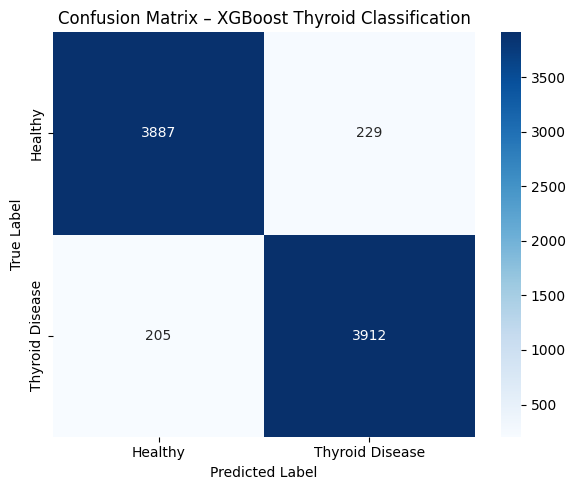

In [78]:
# confusion matrix as Diagram

class_labels = ["Healthy", "Thyroid Disease"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – XGBoost Thyroid Classification")
plt.tight_layout()
plt.show()
